In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


In [101]:
df = pd.read_excel('datasets/2016.xlsx')

In [102]:
df.columns

Index(['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface',
       'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'WPts', 'LPts',
       'W1', 'L1', 'W2', 'L2', 'W3', 'L3', 'W4', 'L4', 'W5', 'L5', 'Wsets',
       'Lsets', 'Comment', 'B365W', 'B365L', 'EXW', 'EXL', 'LBW', 'LBL', 'PSW',
       'PSL', 'MaxW', 'MaxL', 'AvgW', 'AvgL'],
      dtype='object')

In [103]:
df = df[['Location','Tournament','Winner', 'Loser','WRank','LRank','B365W', 'B365L']]

In [104]:
df['WL']=df.WRank<df.LRank

In [105]:
colors = {True:'blue', False:'red'}

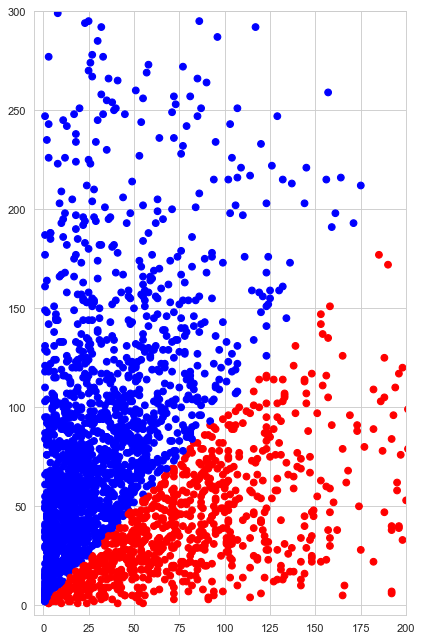

In [106]:
plt.figure(figsize=(6, 10), dpi=80)
plt.scatter(df.WRank, df.LRank, c=df.WL.apply(lambda x: colors[x]))
plt.xlim(-5, 200)
plt.ylim(-5, 300)
plt.show()

In [107]:
df.WL.value_counts()

True     1756
False     870
Name: WL, dtype: int64

In [109]:
df.describe()

,WRank,LRank,B365W,B365L
count,2625.000000,2619.000000,2623.000000,2623.000000
mean,58.149714,91.478045,1.860923,3.821109
std,79.311697,119.171714,1.374220,4.263202
min,1.000000,1.000000,1.000000,1.010000
25%,16.000000,33.000000,1.220000,1.720000
50%,38.000000,62.000000,1.440000,2.620000
75%,73.000000,103.000000,2.000000,4.000000
max,1045.000000,1809.000000,26.000000,51.000000


Strategia RANKING: expectation con quote mediane

In [114]:
1756/(1756+870)

0.6686976389946687

In [120]:
0.668*0.44 + (1-0.668)*-1

-0.03807999999999995

In [121]:
0.668*-1 + (1-0.668)*1.62

-0.13016000000000005

Strategia BOOKIE

In [123]:
df['bookok'] = df.B365W < df.B365L

In [125]:
df.bookok.value_counts()

True     1835
False     791
Name: bookok, dtype: int64

In [127]:
1835/(1835+791)

0.6987814166031988

In [128]:
0.698*0.44 + (1-0.698)*-1

0.005119999999999958

In [129]:
0.698*-1 + (1-0.698)*1.62

-0.20875999999999983

In [98]:
tmpdf = df[(df.WRank==5)|(df.LRank==5)].copy()

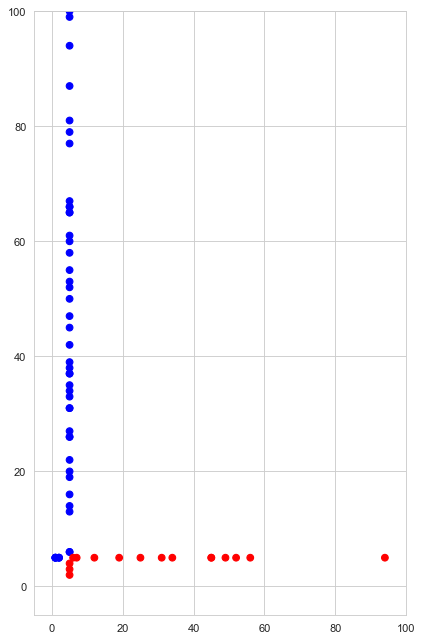

In [99]:
plt.figure(figsize=(6, 10), dpi=80)
plt.scatter(tmpdf.WRank, tmpdf.LRank, c=tmpdf.WL.apply(lambda x: colors[x]))
plt.xlim(-5, 100)
plt.ylim(-5, 100)
plt.show()

## Elo rating

In [111]:
import glob
filenames=list(glob.glob("datasets/20*.xls*"))

In [112]:
l = [pd.read_excel(filename,encoding='latin-1') for filename in filenames]

In [113]:
data = pd.concat(l,0)

C:\Users\crisimo\Apps\WPy64-3760\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [114]:
### Data cleaning
data=data.sort_values("Date")

In [115]:
data["WRank"]=data["WRank"].replace(np.nan,0)
data["WRank"]=data["WRank"].replace("NR",2000)
data["LRank"]=data["LRank"].replace(np.nan,0)
data["LRank"]=data["LRank"].replace("NR",2000)
data["WRank"]=data["WRank"].astype(int)
data["LRank"]=data["LRank"].astype(int)
data["Wsets"]=data["Wsets"].astype(float)
data["Lsets"]=data["Lsets"].replace("`1",1)
data["Lsets"]=data["Lsets"].astype(float)
data=data.reset_index(drop=True)

In [93]:
data = pd.read_csv('datasets/data.csv')

In [117]:
def compute_elo_rankings(data):
    """
    Given the list on matches in chronological order, for each match, computes 
    the elo ranking of the 2 players at the beginning of the match
    
    """
    print("Elo rankings computing...")
    players=list(pd.Series(list(data.Winner)+list(data.Loser)).value_counts().index)
    elo=pd.Series(np.ones(len(players))*1500,index=players)
    ranking_elo=[(1500,1500)]
    for i in range(1,len(data)):
        w=data.iloc[i-1,:].Winner
        l=data.iloc[i-1,:].Loser
        elow=elo[w]
        elol=elo[l]
        pwin=1 / (1 + 10 ** ((elol - elow) / 400))    
        K_win=32
        K_los=32
        new_elow=elow+K_win*(1-pwin)
        new_elol=elol-K_los*(1-pwin)
        elo[w]=new_elow
        elo[l]=new_elol
        ranking_elo.append((elo[data.iloc[i,:].Winner],elo[data.iloc[i,:].Loser])) 
        if i%5000==0:
            print(str(i)+" matches computed...")
    ranking_elo=pd.DataFrame(ranking_elo,columns=["elo_winner","elo_loser"])    
    ranking_elo["proba_elo"]=1 / (1 + 10 ** ((ranking_elo["elo_loser"] - ranking_elo["elo_winner"]) / 400))   
    return ranking_elo

In [118]:
elo_rankings = compute_elo_rankings(data)
data = pd.concat([data,elo_rankings],1)

Elo rankings computing...
5000 matches computed...
10000 matches computed...


In [119]:
data.tail()

,ATP,AvgL,AvgW,B365L,B365W,Best of,Comment,Court,Date,EXL,...,W3,W4,W5,WPts,WRank,Winner,Wsets,elo_winner,elo_loser,proba_elo
10709,4,2.21,1.68,2.20,1.66,5,Completed,Outdoor,2020-01-29,NaN,...,6.0,6.0,NaN,3345.0,7,Zverev A.,3.0,1812.422775,1808.159798,0.506135
10710,4,1.32,3.42,1.36,3.20,5,Completed,Outdoor,2020-01-29,NaN,...,4.0,7.0,NaN,5890.0,5,Thiem D.,3.0,1920.137961,2085.318739,0.278713
10711,4,6.25,1.13,6.50,1.11,5,Completed,Outdoor,2020-01-30,NaN,...,6.0,NaN,NaN,9720.0,2,Djokovic N.,3.0,2044.398779,2017.834044,0.538155
10712,4,2.69,1.48,2.62,1.50,5,Completed,Outdoor,2020-01-31,NaN,...,7.0,7.0,NaN,5890.0,5,Thiem D.,3.0,1943.219161,1828.226467,0.659699
10713,4,3.89,1.27,4.00,1.25,5,Completed,Outdoor,2020-02-02,NaN,...,2.0,6.0,6.0,9720.0,2,Djokovic N.,2.0,2059.177806,1954.108807,0.646760


In [120]:
data[data.elo_winner > data.elo_loser]

,ATP,AvgL,AvgW,B365L,B365W,Best of,Comment,Court,Date,EXL,...,W3,W4,W5,WPts,WRank,Winner,Wsets,elo_winner,elo_loser,proba_elo
63,2,1.93,1.85,1.90,1.80,3,Completed,Outdoor,2016-01-07,2.00,...,6.0,NaN,NaN,209.0,248,Ramanathan R.,2.0,1516.000000,1500.000000,0.523010
72,1,1.32,3.32,1.30,3.40,3,Completed,Outdoor,2016-01-08,1.33,...,6.0,NaN,NaN,1675.0,18,Tomic B.,2.0,1532.000000,1516.736307,0.521952
74,2,1.39,2.95,1.36,3.00,3,Completed,Outdoor,2016-01-08,1.40,...,7.0,NaN,NaN,941.0,44,Coric B.,2.0,1532.000000,1516.736307,0.521952
75,2,4.81,1.18,5.00,1.16,3,Completed,Outdoor,2016-01-08,4.30,...,6.0,NaN,NaN,939.0,45,Bedene A.,2.0,1532.000000,1531.263693,0.501060
76,1,1.39,2.98,1.36,3.00,3,Completed,Outdoor,2016-01-08,1.40,...,6.0,NaN,NaN,1600.0,20,Thiem D.,2.0,1532.000000,1516.736307,0.521952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10708,4,6.28,1.12,6.00,1.12,5,Completed,Outdoor,2020-01-28,NaN,...,7.0,NaN,NaN,9720.0,2,Djokovic N.,3.0,2040.154138,1713.951771,0.867355
10709,4,2.21,1.68,2.20,1.66,5,Completed,Outdoor,2020-01-29,NaN,...,6.0,6.0,NaN,3345.0,7,Zverev A.,3.0,1812.422775,1808.159798,0.506135
10711,4,6.25,1.13,6.50,1.11,5,Completed,Outdoor,2020-01-30,NaN,...,6.0,NaN,NaN,9720.0,2,Djokovic N.,3.0,2044.398779,2017.834044,0.538155
10712,4,2.69,1.48,2.62,1.50,5,Completed,Outdoor,2020-01-31,NaN,...,7.0,7.0,NaN,5890.0,5,Thiem D.,3.0,1943.219161,1828.226467,0.659699


In [121]:
6698/10713

0.6252216932698591